In [25]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision
import numpy as np

from matplotlib import pyplot as plt

In [26]:
# Get data
from PIL import Image

ANNOTATIONS_FILE_URI = lambda x: f"../data/processed/{x}/_annotations.txt"

def get_annotations(file_uri):
    with open(file_uri, "r") as annotation_file:
        annotations = annotation_file.readlines()
    split_annotations = [annotation.split(" ") for annotation in annotations]
    return [(split_annotation[0], split_annotation[1]) for split_annotation in split_annotations]

def get_tensors(annotations, env):
    images = []
    labels = []

    for (image_name, label) in annotations:
        image = Image.open(f"../data/processed/{env}/{image_name}")

        labels.append(int(label))

        image = transforms.ToTensor()(image)
        images.append(image)
    
    return torch.stack(images), torch.LongTensor(labels)-1

train_annotations = get_annotations(ANNOTATIONS_FILE_URI("train"))
X_train_tensor, Y_train_tensor = get_tensors(train_annotations, "train")

test_annotations = get_annotations(ANNOTATIONS_FILE_URI("test"))
x_test_tensor, y_test_tensor = get_tensors(test_annotations, "test")

print(X_train_tensor.shape)
print(Y_train_tensor.shape)

print(x_test_tensor.shape)
print(y_test_tensor.shape)

torch.Size([229, 1, 28, 28])
torch.Size([229])
torch.Size([30, 1, 28, 28])
torch.Size([30])


In [27]:
import torch.nn.functional as F
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

class MyCnnModel(nn.Module):
    def __init__(self, numChannels=1, classes=6):
        super(MyCnnModel, self).__init__()

        self.conv1 = Conv2d(in_channels=numChannels, out_channels=20,
                                kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.conv2 = Conv2d(in_channels=20, out_channels=50,
                                kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))

        self.fc1 = Linear(in_features=800, out_features=500)
        self.relu3 = ReLU()

        self.fc2 = Linear(in_features=500, out_features=classes)
        self.logSoftmax = LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = flatten(x, 1)
        x = self.fc1(x)
        x = self.relu3(x)
        output = self.fc2(x)
        return output

                  

In [28]:
model = MyCnnModel()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

X_train_tensor = X_train_tensor.to(device)
Y_train_tensor = Y_train_tensor.to(device)

x_test_tensor = x_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [29]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200
loss_values = list()

In [30]:
model.train()

for epoch in range(1, num_epochs):
    outputs = model(X_train_tensor)
    loss = criterion(outputs, Y_train_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print("Epoch - %d, loss  %0.5f" %(epoch, loss.item()))
    loss_values.append(loss.item())

    

Epoch - 1, loss  1.79202
Epoch - 2, loss  1.78685
Epoch - 3, loss  1.78456
Epoch - 4, loss  1.78075
Epoch - 5, loss  1.77653
Epoch - 6, loss  1.77151
Epoch - 7, loss  1.76563
Epoch - 8, loss  1.75849
Epoch - 9, loss  1.75039
Epoch - 10, loss  1.74117
Epoch - 11, loss  1.73072
Epoch - 12, loss  1.71928
Epoch - 13, loss  1.70680
Epoch - 14, loss  1.69362
Epoch - 15, loss  1.68104
Epoch - 16, loss  1.66980
Epoch - 17, loss  1.65444
Epoch - 18, loss  1.64086
Epoch - 19, loss  1.63404
Epoch - 20, loss  1.61063
Epoch - 21, loss  1.60199
Epoch - 22, loss  1.58272
Epoch - 23, loss  1.56856
Epoch - 24, loss  1.54635
Epoch - 25, loss  1.53284
Epoch - 26, loss  1.50920
Epoch - 27, loss  1.48921
Epoch - 28, loss  1.46702
Epoch - 29, loss  1.44592
Epoch - 30, loss  1.42334
Epoch - 31, loss  1.39834
Epoch - 32, loss  1.36999
Epoch - 33, loss  1.34222
Epoch - 34, loss  1.31385
Epoch - 35, loss  1.28876
Epoch - 36, loss  1.26862
Epoch - 37, loss  1.28187
Epoch - 38, loss  1.25026
Epoch - 39, loss  1.1

Text(0, 0.5, 'loss')

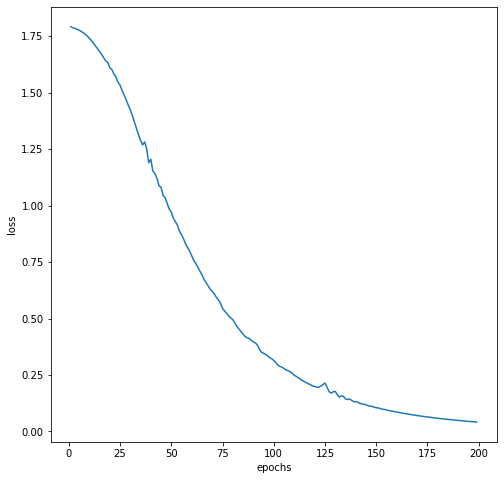

In [31]:
x = (range(1,num_epochs))

plt.figure(figsize=(8,8))
plt.plot(x, loss_values)
plt.xlabel("epochs")
plt.ylabel("loss")

In [32]:
model.eval()

MyCnnModel(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=6, bias=True)
  (logSoftmax): LogSoftmax(dim=1)
)

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [34]:
with torch.no_grad():
    correct = 0
    total = 0
    
    outputs = model(x_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    
    y_test = y_test_tensor.cpu().numpy()
    predicted = predicted.cpu()
    
    print(y_test+1)
    print(predicted.numpy()+1)
    
    print("Accuracy: ", accuracy_score(predicted, y_test))
    print("Precision: ", precision_score(predicted, y_test, average="weighted"))

[1 4 3 4 1 1 1 5 6 3 4 2 4 6 2 3 4 2 6 4 5 2 5 2 1 5 6 4 4 4]
[1 4 3 4 1 1 1 5 4 3 4 2 4 6 2 3 4 2 6 4 5 2 4 2 1 5 6 4 4 4]
Accuracy:  0.9333333333333333
Precision:  0.95
